In [97]:
# %%writefile Ind_VR_OSC.py

import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)

import Ind_Model_Base

import numpy as np
import pandas as pd

import QUANTAXIS as QA

import matplotlib.pyplot as plt


import Analysis_Funs as af
# import base.JuUnits as ju

# %load_ext autoreload
# %autoreload 2
# %aimport Analysis_Funs,Ind_Model_Base


class VR(Ind_Model_Base.Ind_Model):
    """成交量变异率（VR）"""
    optimum_param={'valid':False, 'main':'vr', 'desition_direct':1, 'freq':'d','neutralize':{'enable':False,'static_mv':False}}
    
    def __init__(self,data, frequence=QA.FREQUENCE.DAY):
        super().__init__(data, 'VR', frequence)
        self.renko_objs={}
        
        ### 正式使用时由实例设置为true来加速
#         self.set_ignore_sub_ind(False)
        

    def on_set_params_default(self):
        return {}
    
        
    def on_indicator_structuring(self, data):
        return self.excute_for_multicode(data, self.kernel, **self.pramas)
    
    def on_desition_structuring(self, data, ind_data):
        """
        """
#         JXSX = self.excute_for_multicode(self.ind_df,
#                                          lambda x: pd.DataFrame(af.feature_JXSX_timeline(x['direct']),
#                                          index=x.index,
#                                          columns=['feature_RENKO_JXSX']))
#         self.ind_df = pd.concat([self.ind_df, JXSX, ],axis=1)
        return None #pd.concat([JXSX,continuity],axis=1)
        
    def kernel(self,dataframe):
        window = 24
        ma = 6
        
        if len(dataframe)< window+1:
            return None
        
        sign = np.sign(smpl.get_current_return(dataframe,'close'))
        up = np.where(sign>0,1,0)
        down = np.where(sign<0,1,0)
        stay = np.where(sign==0,1,0)
        vol = dataframe.volume
        
        res=[np.nan]*(window-1)
        for idx in range(window,len(sign)+1):
            AVS = (vol[idx-window:idx]*up[idx-window:idx]).sum()
            BVS = (vol[idx-window:idx]*down[idx-window:idx]).sum()
            CVS = (vol[idx-window:idx]*stay[idx-window:idx]).sum()
            VR = (AVS+0.5*CVS)/(BVS+0.5*CVS)
            res.append(VR)
        vr_df = pd.DataFrame(res,index=sign.index,columns=['vr'])
        

        return vr_df.rolling(ma).mean()

    def plot(self):
        if self.fast_mode:
            raise 'fast_mode is True,cant draw chart'
        
        


Wall time: 448 ms


<AxesSubplot:xlabel='date,code'>

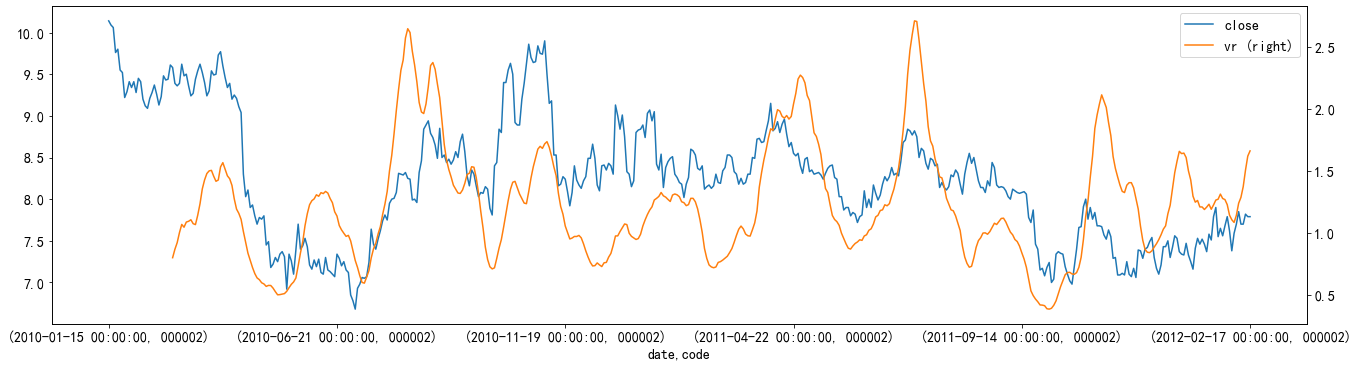

In [85]:
%%time
# import sys
# import os 
# module_path = os.path.abspath(os.path.join('..')) 
# if module_path not in sys.path: 
#     sys.path.append(module_path)
# import tools.Sample_Tools as smpl
# import Analysis_Funs as af
# import base.JuUnits as ju
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

sign = np.sign(smpl.get_current_return(data,'close'))
up = np.where(sign>0,1,0)
down = np.where(sign<0,1,0)
stay = np.where(sign==0,1,0)
vol = data.volume

window = 24
ma = 6
res=[np.nan]*(window-1)
for idx in range(window,len(sign)+1):
    AVS = (vol[idx-window:idx]*up[idx-window:idx]).sum()
    BVS = (vol[idx-window:idx]*down[idx-window:idx]).sum()
    CVS = (vol[idx-window:idx]*stay[idx-window:idx]).sum()
    VR = (AVS+0.5*CVS)/(BVS+0.5*CVS)
    res.append(VR)
vr_df = pd.DataFrame(res,index=sign.index,columns=['vr'])

pd.concat([data['close'],vr_df.rolling(ma).mean()],axis=1).plot(secondary_y=['vr'],figsize=(1620/72,420/72))



<ipython-input-97-e4c3fff0500b>:74: RuntimeWarning: divide by zero encountered in double_scalars
  VR = (AVS+0.5*CVS)/(BVS+0.5*CVS)


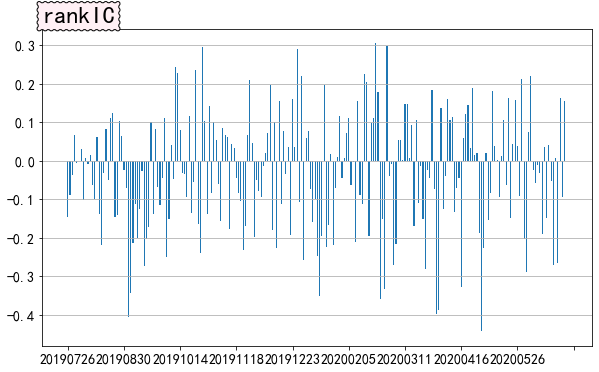

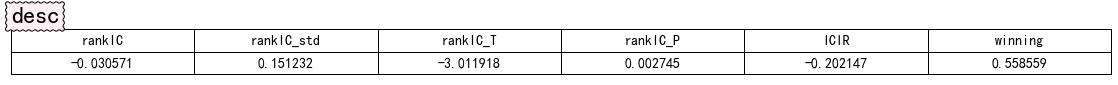

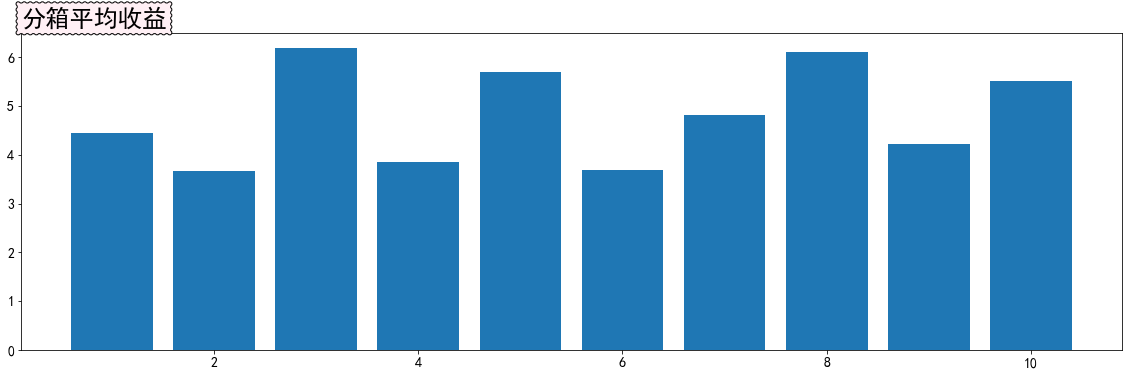

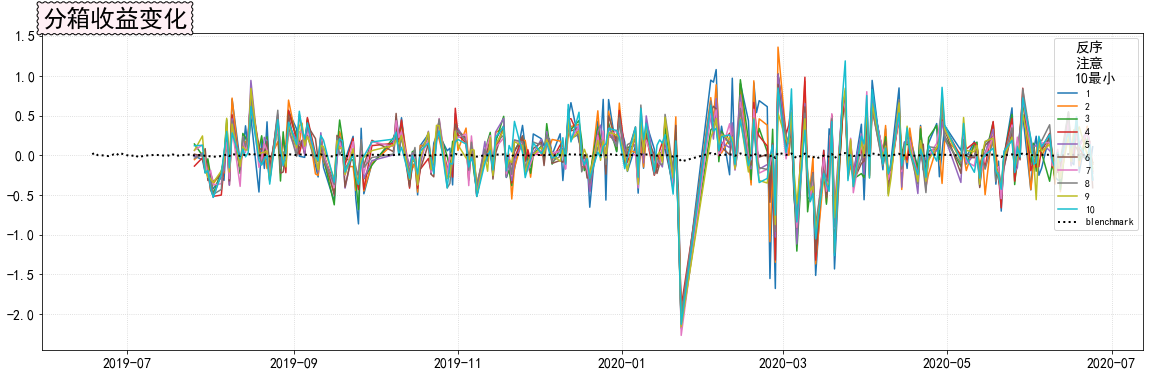

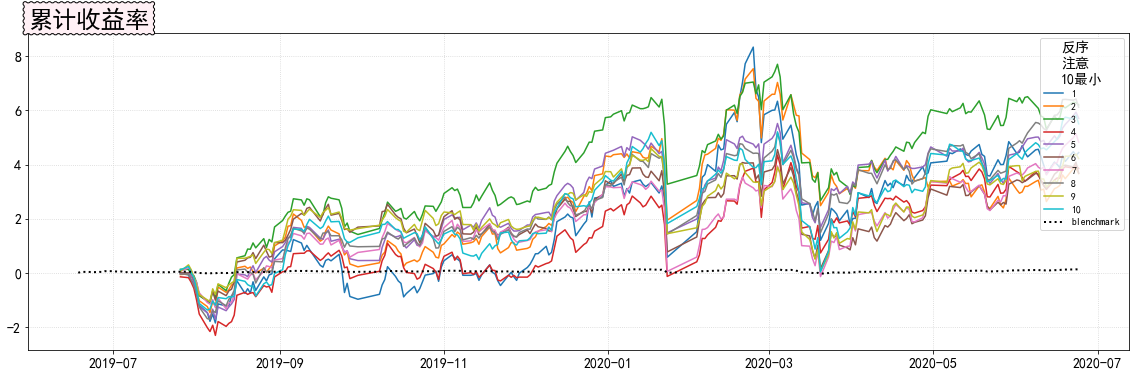

Wall time: 57 s


In [98]:
%%time
from tools.Test_Tools import FactorTest
# %load_ext autoreload
# %autoreload 1
# %aimport tools.Test_Tools,ind.Ind_RENKO

# 沪深300
test = FactorTest(VR, sample='沪深300', freq="d",end='2020-06-29',gap=250,only_main=True,neutralize={'enable':False,'static_mv':False},target_field='vr')
test.process()
# test.process_multi()
test.plot()